<a href="https://colab.research.google.com/github/atousaz/vehicle_tracking/blob/main/bytetrack_DETR_a2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
root = '/content/drive/'
drive.mount(root)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Install dependencies**

In [ ]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [ ]:
# COCO classes
CLASSES = [
     'car', 
     'truck'
]


# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
first_class_index = 0

first_class_index = 0
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.


  num_classes = 2

  finetuned_classes = [
      'car','truck'
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.  

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 2

  finetuned_classes = [
      'N/A', 'balloon',
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 2
Fine-tuned classes: ['car', 'truck']


In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

## Tracker

--- **Load bytetracke and requirements**



In [ ]:
# == Download the repo content and install dependencies ==
#
!git clone https://github.com/ifzhang/ByteTrack.git
%cd /content/drive/MyDrive/Collab Notebooks/ByteTrack/
#!git clone https://github.com/ifzhang/ByteTrack.git

/content/drive/MyDrive/Collab Notebooks/ByteTrack


In [ ]:
cd ByteTrack/

/content/drive/MyDrive/Collab Notebooks/ByteTrack/ByteTrack


In [ ]:
# == Install dependencies ==
!pip3 install cython
!pip3 install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip3 install cython_bbox

#%cd /content/ByteTrack/
!pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-y5ti8pps
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-y5ti8pps
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265178 sha256=dce26270bf68c88c998f85b34210d70d540f3f9576bb198fc7dc576f6d255d49
  Stored in directory: /tmp/pip-ephem-wheel-cache-timbtdd6/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 184 kB/s 
  Created wheel for cython-bbox: filename=cython_bbox-0.1.3-cp37-cp37m-linux_x86_64.whl size=58458 sha256=01451eeb6ec49708772dfb8d601e478ebbb8127bfe9075b514ec6983ced649a2
  Stored in directory: /root/.cache/pip/wheels/51/82/21/5def8bc98ae4ea436d7f0decb7194d20d7e3e6d0578a4129d7
Successfully built cython-bbox
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 2.7 MB/s 
     |████████████████████████████████| 108 kB 9.2 MB/s 
     |████████████████████████████████| 1.5 MB 53.7 MB/s 
     |████████████████████████████████| 161 kB 63.9 MB/s 
     |████████████████████████████████| 177 kB 55.9 MB/s 
     |████████████████████████████████| 14.5 MB 24.7 MB/s 
     |████████████████████████████████| 4.5 MB 46.8 MB/s 
     |███████████████████████████

In [ ]:
# Import required packages/modules first

from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T
import sys
from os.path import join
import os 
import cv2
import pandas as pd
from collections import deque
import os
import os.path as osp
import copy
import torch
import torch.nn.functional as F

from yolox.tracker.kalman_filter import KalmanFilter
from yolox.tracker import matching
from yolox.tracker.basetrack import BaseTrack, TrackState


In [ ]:
class STrack(BaseTrack):
    shared_kalman = KalmanFilter()
    def __init__(self, tlwh, score):

        # wait activate
        self._tlwh = np.asarray(tlwh, dtype=np.float)
        self.kalman_filter = None
        self.mean, self.covariance = None, None
        self.is_activated = False

        self.score = score
        self.tracklet_len = 0

    def predict(self):
        mean_state = self.mean.copy()
        if self.state != TrackState.Tracked:
            mean_state[7] = 0
        self.mean, self.covariance = self.kalman_filter.predict(mean_state, self.covariance)

    @staticmethod
    def multi_predict(stracks):
        if len(stracks) > 0:
            multi_mean = np.asarray([st.mean.copy() for st in stracks])
            multi_covariance = np.asarray([st.covariance for st in stracks])
            for i, st in enumerate(stracks):
                if st.state != TrackState.Tracked:
                    multi_mean[i][7] = 0
            multi_mean, multi_covariance = STrack.shared_kalman.multi_predict(multi_mean, multi_covariance)
            for i, (mean, cov) in enumerate(zip(multi_mean, multi_covariance)):
                stracks[i].mean = mean
                stracks[i].covariance = cov

    def activate(self, kalman_filter, frame_id):
        """Start a new tracklet"""
        self.kalman_filter = kalman_filter
        self.track_id = self.next_id()
        self.mean, self.covariance = self.kalman_filter.initiate(self.tlwh_to_xyah(self._tlwh))

        self.tracklet_len = 0
        self.state = TrackState.Tracked
        if frame_id == 1:
            self.is_activated = True
        # self.is_activated = True
        self.frame_id = frame_id
        self.start_frame = frame_id

    def re_activate(self, new_track, frame_id, new_id=False):
        self.mean, self.covariance = self.kalman_filter.update(
            self.mean, self.covariance, self.tlwh_to_xyah(new_track.tlwh)
        )
        self.tracklet_len = 0
        self.state = TrackState.Tracked
        self.is_activated = True
        self.frame_id = frame_id
        if new_id:
            self.track_id = self.next_id()
        self.score = new_track.score

    def update(self, new_track, frame_id):
        """
        Update a matched track
        :type new_track: STrack
        :type frame_id: int
        :type update_feature: bool
        :return:
        """
        self.frame_id = frame_id
        self.tracklet_len += 1

        new_tlwh = new_track.tlwh
        self.mean, self.covariance = self.kalman_filter.update(
            self.mean, self.covariance, self.tlwh_to_xyah(new_tlwh))
        self.state = TrackState.Tracked
        self.is_activated = True

        self.score = new_track.score

    @property
    # @jit(nopython=True)
    def tlwh(self):
        """Get current position in bounding box format `(top left x, top left y,
                width, height)`.
        """
        if self.mean is None:
            return self._tlwh.copy()
        ret = self.mean[:4].copy()
        ret[2] *= ret[3]
        ret[:2] -= ret[2:] / 2
        return ret

    @property
    # @jit(nopython=True)
    def tlbr(self):
        """Convert bounding box to format `(min x, min y, max x, max y)`, i.e.,
        `(top left, bottom right)`.
        """
        ret = self.tlwh.copy()
        ret[2:] += ret[:2]
        return ret

    @staticmethod
    # @jit(nopython=True)
    def tlwh_to_xyah(tlwh):
        """Convert bounding box to format `(center x, center y, aspect ratio,
        height)`, where the aspect ratio is `width / height`.
        """
        ret = np.asarray(tlwh).copy()
        ret[:2] += ret[2:] / 2
        ret[2] /= ret[3]
        return ret

    def to_xyah(self):
        return self.tlwh_to_xyah(self.tlwh)

    @staticmethod
    # @jit(nopython=True)
    def tlbr_to_tlwh(tlbr):
        ret = np.asarray(tlbr).copy()
        ret[2:] -= ret[:2]
        return ret

    @staticmethod
    # @jit(nopython=True)
    def tlwh_to_tlbr(tlwh):
        ret = np.asarray(tlwh).copy()
        ret[2:] += ret[:2]
        return ret

    def __repr__(self):
        return 'OT_{}_({}-{})'.format(self.track_id, self.start_frame, self.end_frame)


class BYTETracker(object):
    def __init__(self,  frame_rate=30):
        self.tracked_stracks = []  # type: list[STrack]
        self.lost_stracks = []  # type: list[STrack]
        self.removed_stracks = []  # type: list[STrack]
        
        self.det_thresh = 0.6
        self.frame_id = 0
        self.buffer_size = int(frame_rate / 30*30)
       # self.args = args
       # self.det_thresh = args.track_thresh

       # self.det_thresh = args.track_thresh + 0.1
	
       # self.buffer_size = int(frame_rate / 30.0 * args.track_buffer)
	

        self.max_time_lost = self.buffer_size
        self.kalman_filter = KalmanFilter()

    def update(self, output_results, img_info, img_size):
        self.frame_id += 1
        activated_starcks = []
        refind_stracks = []
        lost_stracks = []
        removed_stracks = []

        if output_results.shape[1] == 5:
            scores = output_results[:, 4]
            bboxes = output_results[:, :4]
       # else:
           # output_results = output_results.cpu().numpy()
           # scores = output_results[:, 4] * output_results[:, 5]
           # bboxes = output_results[:, :4]  # x1y1x2y2

        img_h, img_w = img_info[0], img_info[1]
        scale = min(img_size[0] / float(img_h), img_size[1] / float(img_w))
        bboxes /= scale

        remain_inds = scores > 0.5
        inds_low = scores > 0.1
        inds_high = scores < 0.5

        inds_second = np.logical_and(inds_low, inds_high)
        dets_second = bboxes[inds_second]
        dets = bboxes[remain_inds]
        scores_keep = scores[remain_inds]
        scores_second = scores[inds_second]

        if len(dets) > 0:
            '''Detections'''
            detections = [STrack(STrack.tlbr_to_tlwh(tlbr), s) for
                          (tlbr, s) in zip(dets, scores_keep)]
        else:
            detections = []

        ''' Add newly detected tracklets to tracked_stracks'''
        unconfirmed = []
        tracked_stracks = []  # type: list[STrack]
        for track in self.tracked_stracks:
            if not track.is_activated:
                unconfirmed.append(track)
            else:
                tracked_stracks.append(track)

        ''' Step 2: First association, with high score detection boxes'''
        strack_pool = joint_stracks(tracked_stracks, self.lost_stracks)
        # Predict the current location with KF
        STrack.multi_predict(strack_pool)
        dists = matching.iou_distance(strack_pool, detections)
        #if not self.args.mot20:
        dists = matching.fuse_score(dists, detections)
        matches, u_track, u_detection = matching.linear_assignment(dists, thresh=0.8)

        for itracked, idet in matches:
            track = strack_pool[itracked]
            det = detections[idet]
            if track.state == TrackState.Tracked:
                track.update(detections[idet], self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        ''' Step 3: Second association, with low score detection boxes'''
        # association the untrack to the low score detections
        if len(dets_second) > 0:
            '''Detections'''
            detections_second = [STrack(STrack.tlbr_to_tlwh(tlbr), s) for
                          (tlbr, s) in zip(dets_second, scores_second)]
        else:
            detections_second = []
        r_tracked_stracks = [strack_pool[i] for i in u_track if strack_pool[i].state == TrackState.Tracked]
        dists = matching.iou_distance(r_tracked_stracks, detections_second)
        matches, u_track, u_detection_second = matching.linear_assignment(dists, thresh=0.5)
        for itracked, idet in matches:
            track = r_tracked_stracks[itracked]
            det = detections_second[idet]
            if track.state == TrackState.Tracked:
                track.update(det, self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        for it in u_track:
            track = r_tracked_stracks[it]
            if not track.state == TrackState.Lost:
                track.mark_lost()
                lost_stracks.append(track)

        '''Deal with unconfirmed tracks, usually tracks with only one beginning frame'''
        detections = [detections[i] for i in u_detection]
        dists = matching.iou_distance(unconfirmed, detections)
        #if not self.args.mot20:
        dists = matching.fuse_score(dists, detections)
        matches, u_unconfirmed, u_detection = matching.linear_assignment(dists, thresh=0.7)
        for itracked, idet in matches:
            unconfirmed[itracked].update(detections[idet], self.frame_id)
            activated_starcks.append(unconfirmed[itracked])
        for it in u_unconfirmed:
            track = unconfirmed[it]
            track.mark_removed()
            removed_stracks.append(track)

        """ Step 4: Init new stracks"""
        for inew in u_detection:
            track = detections[inew]
            if track.score < self.det_thresh:
                continue
            track.activate(self.kalman_filter, self.frame_id)
            activated_starcks.append(track)
        """ Step 5: Update state"""
        for track in self.lost_stracks:
            if self.frame_id - track.end_frame > self.max_time_lost:
                track.mark_removed()
                removed_stracks.append(track)

        # print('Ramained match {} s'.format(t4-t3))

        self.tracked_stracks = [t for t in self.tracked_stracks if t.state == TrackState.Tracked]
        self.tracked_stracks = joint_stracks(self.tracked_stracks, activated_starcks)
        self.tracked_stracks = joint_stracks(self.tracked_stracks, refind_stracks)
        self.lost_stracks = sub_stracks(self.lost_stracks, self.tracked_stracks)
        self.lost_stracks.extend(lost_stracks)
        self.lost_stracks = sub_stracks(self.lost_stracks, self.removed_stracks)
        self.removed_stracks.extend(removed_stracks)
        self.tracked_stracks, self.lost_stracks = remove_duplicate_stracks(self.tracked_stracks, self.lost_stracks)
        # get scores of lost tracks
        output_stracks = [track for track in self.tracked_stracks if track.is_activated]

        return output_stracks


def joint_stracks(tlista, tlistb):
    exists = {}
    res = []
    for t in tlista:
        exists[t.track_id] = 1
        res.append(t)
    for t in tlistb:
        tid = t.track_id
        if not exists.get(tid, 0):
            exists[tid] = 1
            res.append(t)
    return res


def sub_stracks(tlista, tlistb):
    stracks = {}
    for t in tlista:
        stracks[t.track_id] = t
    for t in tlistb:
        tid = t.track_id
        if stracks.get(tid, 0):
            del stracks[tid]
    return list(stracks.values())


def remove_duplicate_stracks(stracksa, stracksb):
    pdist = matching.iou_distance(stracksa, stracksb)
    pairs = np.where(pdist < 0.15)
    dupa, dupb = list(), list()
    for p, q in zip(*pairs):
        timep = stracksa[p].frame_id - stracksa[p].start_frame
        timeq = stracksb[q].frame_id - stracksb[q].start_frame
        if timep > timeq:
            dupb.append(q)
        else:
            dupa.append(p)
    resa = [t for i, t in enumerate(stracksa) if not i in dupa]
    resb = [t for i, t in enumerate(stracksb) if not i in dupb]
    return resa, resb

In [ ]:
tracker = BYTETracker()

# **Sunny**

# having path is save_test_frames_pretrained_byte_detr

In [ ]:
pathi='/content/drive/MyDrive/coco/'
save_path = join(pathi,'save_testset_frames_sunny_cam1_pretrained_byte_DETR/')
#!mkdir "{save_path}"

# Sunny data test set would save the result of detection and tracking 

In [ ]:
import os 
path='/content/drive/MyDrive/Collab Notebooks/DETR_training/data/custom/test/'
list_cam1data = os.listdir(path)  
list_cam1data.sort()

### **Lets try on all images** save images and output txt

In [ ]:
import re
from os.path import join
import matplotlib.pylab as plt
import cv2
online_targets_all=[]
lista=[]
for j in range(155,len(list_cam1data)):

  img_ex_path =path+list_cam1data[j]
  im = Image.open(img_ex_path)
  det_img = cv2.imread(img_ex_path)
  img = transform(im).unsqueeze(0)

# propagate through the model
  outputs = model(img)

# keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  scores=[]
  for p in probas[keep]:
    cl = p.argmax()
    score=p[cl].item()
    scores.append(score)

  tempall=[]
  for i in range(len(bboxes_scaled)):
    temp=[bboxes_scaled[i][0].item(),bboxes_scaled[i][1].item(),bboxes_scaled[i][2].item(),bboxes_scaled[i][3].item(),scores[i]]
    tempall.append(temp)

  if (len(tempall)!=0):
    online_targets = tracker.update(np.vstack(tempall),[1280, 960],[1280, 960])
  else:
    continue

  mot_imgid = list_cam1data[j].replace('.PNG','')
  newname = save_path + mot_imgid + '_mot.PNG'
  
  for k in range(len(online_targets)):  
      ele = online_targets[k].tlwh
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(online_targets[k].track_id)) 
      cv2.rectangle(det_img, (x, y), (x+x2, y+y2), (0, 255, 255), 2)
      cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
      tmp=int(re.findall('\d+', list_cam1data[j] )[0]),int(track_label), x,y,x2,y2,1,1,1
      lista.append(tmp)




  cv2.imwrite(newname,det_img)
  #print(newname)



  print(list_cam1data[j])
a=pd.DataFrame(lista)
a.to_csv('/content/drive/MyDrive/Collab Notebooks/detections/sunny_test/pretrained_DETR_Byte_cam1_sunny_testset/seq_01.txt', sep=',', index=False, header=False)


/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


frame_000155.PNG
frame_000156.PNG
frame_000157.PNG
frame_000158.PNG
frame_000159.PNG
frame_000160.PNG
frame_000161.PNG
frame_000162.PNG
frame_000163.PNG
frame_000164.PNG
frame_000165.PNG
frame_000166.PNG
frame_000167.PNG
frame_000168.PNG
frame_000169.PNG
frame_000170.PNG
frame_000171.PNG
frame_000172.PNG
frame_000173.PNG
frame_000174.PNG
frame_000175.PNG
frame_000176.PNG
frame_000177.PNG
frame_000178.PNG
frame_000179.PNG
frame_000180.PNG
frame_000181.PNG
frame_000182.PNG
frame_000183.PNG
frame_000184.PNG
frame_000185.PNG
frame_000186.PNG
frame_000187.PNG
frame_000188.PNG
frame_000189.PNG
frame_000190.PNG
frame_000191.PNG
frame_000192.PNG
frame_000193.PNG
frame_000194.PNG
frame_000195.PNG
frame_000196.PNG
frame_000197.PNG
frame_000198.PNG
frame_000199.PNG
frame_000200.PNG
frame_000201.PNG
frame_000202.PNG
frame_000203.PNG
frame_000204.PNG
frame_000205.PNG
frame_000206.PNG
frame_000207.PNG
frame_000208.PNG
frame_000209.PNG
frame_000210.PNG
frame_000211.PNG
frame_000212.PNG
frame_000213.P

FileNotFoundError: ignored

In [ ]:
a.to_csv('/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/sunny_cam1_testset/pretrained_DETR_Byte_cam1_sunny_testset/seq_01.txt', sep=',', index=False, header=False)


##  **test set evaluation** 

In [ ]:
cd '/content/drive/MyDrive/Collab Notebooks/gt/'

/content/drive/MyDrive/Collab Notebooks/gt


In [ ]:
pip install git+https://github.com/cheind/py-motmetrics.git

  Cloning https://github.com/cheind/py-motmetrics.git to /tmp/pip-req-build-nk1hqzf6
  Running command git clone -q https://github.com/cheind/py-motmetrics.git /tmp/pip-req-build-nk1hqzf6


In [ ]:
Layout for ground truth data
    <GT_ROOT>/<SEQUENCE_1>/gt/gt.txt
    <GT_ROOT>/<SEQUENCE_2>/gt/gt.txt
    ...

Layout for test data
    <TEST_ROOT>/<SEQUENCE_1>.txt
    <TEST_ROOT>/<SEQUENCE_2>.txt
    ...

In [ ]:
!python -m motmetrics.apps.eval_motchallenge '/content/drive/MyDrive/Collab Notebooks/gt/sunny_cam1_testset/' '/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/sunny_cam1_testset/pretrained_DETR_Byte_cam1_sunny_testset/'

07:16:37 INFO - Found 1 groundtruths and 1 test files.
07:16:37 INFO - Available LAP solvers ['scipy']
07:16:37 INFO - Default LAP solver 'scipy'
07:16:37 INFO - Loading files.
07:16:38 INFO - Comparing seq_01...
07:16:38 INFO - Running metrics
07:16:38 INFO - partials: 0.082 seconds.
07:16:38 INFO - mergeOverall: 0.085 seconds.
         IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP   FN IDs  FM   MOTA  MOTP IDt IDa IDm
seq_01  22.2% 27.5% 18.6% 18.7% 27.7% 32  0  5 27 955 1587   2  34 -30.3% 0.318   1   2   1
OVERALL 22.2% 27.5% 18.6% 18.7% 27.7% 32  0  5 27 955 1587   2  34 -30.3% 0.318   1   2   1
07:16:38 INFO - Completed


# trainset evaluation pretrained DETRbyte

In [ ]:
%%time

import warnings
warnings.filterwarnings('ignore')

pathi='/content/drive/MyDrive/coco/'
save_path = join(pathi,'save_trainset_frames_sunny_cam1_pretrained_byte_DETR/')
!mkdir "{save_path}"


import os 
path='/content/drive/MyDrive/Collab Notebooks/DETR_training/data/custom/train2017/'
list_cam1data = os.listdir(path)  
list_cam1data.sort()
import re
from os.path import join
import matplotlib.pylab as plt
import cv2
online_targets_all=[]
lista=[]
for j in range(len(list_cam1data)):

  img_ex_path =path+list_cam1data[j]
  im = Image.open(img_ex_path)
  det_img = cv2.imread(img_ex_path)
  img = transform(im).unsqueeze(0)

# propagate through the model
  outputs = model(img)

# keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  scores=[]
  for p in probas[keep]:
    cl = p.argmax()
    score=p[cl].item()
    scores.append(score)

  tempall=[]
  for i in range(len(bboxes_scaled)):
    temp=[bboxes_scaled[i][0].item(),bboxes_scaled[i][1].item(),bboxes_scaled[i][2].item(),bboxes_scaled[i][3].item(),scores[i]]
    tempall.append(temp)

  
  online_targets = tracker.update(np.vstack(tempall),[1280, 960],[1280, 960])
  
    

  mot_imgid = list_cam1data[j].replace('.PNG','')
  newname = save_path + mot_imgid + '_mot.PNG'
  
  for k in range(len(online_targets)):  
      ele = online_targets[k].tlwh
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(online_targets[k].track_id)) 
      cv2.rectangle(det_img, (x, y), (x+x2, y+y2), (0, 255, 255), 2)
      cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
      tmp=int(re.findall('\d+', list_cam1data[j] )[0]),int(track_label), x,y,x2,y2,1,1,1
      lista.append(tmp)




  cv2.imwrite(newname,det_img)
  #print(newname)



  #print(list_cam1data[j])
a=pd.DataFrame(lista)
a.to_csv('/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/sunny_cam1_trainset/pretrained_DETR_Byte_cam1_sunny_traintset/seq_01.txt', sep=',', index=False, header=False)

!python -m motmetrics.apps.eval_motchallenge '/content/drive/MyDrive/Collab Notebooks/gt/sunny_cam1_trainset/'    '/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/sunny_cam1_trainset/pretrained_DETR_Byte_cam1_sunny_traintset/'

mkdir: cannot create directory ‘/content/drive/MyDrive/coco/save_trainset_frames_sunny_cam1_pretrained_byte_DETR/’: File exists
06:39:33 INFO - Found 1 groundtruths and 1 test files.
06:39:33 INFO - Available LAP solvers ['lap', 'scipy']
06:39:33 INFO - Default LAP solver 'lap'
06:39:33 INFO - Loading files.
06:39:34 INFO - Comparing seq_01...
06:39:36 INFO - Running metrics
06:39:36 INFO - partials: 0.277 seconds.
06:39:36 INFO - mergeOverall: 0.281 seconds.
         IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML   FP   FN IDs   FM   MOTA  MOTP IDt IDa IDm
seq_01  20.6% 27.8% 16.4% 18.7% 31.6% 70  0 24 46 4112 8259  65  330 -22.4% 0.373  13  46   5
OVERALL 20.6% 27.8% 16.4% 18.7% 31.6% 70  0 24 46 4112 8259  65  330 -22.4% 0.373  13  46   5
06:39:36 INFO - Completed
CPU times: user 44min 43s, sys: 1min 23s, total: 46min 6s
Wall time: 49min 23s


# plot the result on image

In [ ]:
save_path='/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/'

In [ ]:
from os.path import join
import matplotlib.pylab as plt
import cv2
online_targets_all=[]
lista=[]
for j in range(len(list_cam1data)):

  img_ex_path =path+list_cam1data[j]
  im = Image.open(img_ex_path)
  det_img = cv2.imread(img_ex_path)
  img = transform(im).unsqueeze(0)

# propagate through the model
  outputs = model(img)

# keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  scores=[]
  for p in probas[keep]:
    cl = p.argmax()
    score=p[cl].item()
    scores.append(score)

  tempall=[]
  for i in range(len(bboxes_scaled)):
    temp=[bboxes_scaled[i][0].item(),bboxes_scaled[i][1].item(),bboxes_scaled[i][2].item(),bboxes_scaled[i][3].item(),scores[i]]
    tempall.append(temp)

  online_targets = tracker.update(np.vstack(tempall),[1280, 960],[1280, 960])
  
  
  mot_imgid = list_cam1data[j].replace('.PNG','')
  newname = save_path + mot_imgid + '_mot.PNG'

  for j in range(len(online_targets)):  
      ele = online_targets[j].tlwh
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(online_targets[j].track_id)) 
      cv2.rectangle(det_img, (x, y), (x+x2, y+y2), (0, 255, 255), 2)

      cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)

  cv2.imwrite(newname,det_img)
  print(newname)


/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000001_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000002_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000003_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000004_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000005_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000006_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000007_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000008_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000009_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000010_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000011_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000012_mot.PNG
/content/drive/MyDrive/coco/save_Byte_DETR_test_frame_1min/000013_mot.PNG
/content/drive/MyDrive/coco/save_Byte_

In [ ]:
from os.path import join
import matplotlib.pylab as plt
import cv2
online_targets_all=[]
lista=[]
for j in range(len(list_cam1data)):

  img_ex_path =path+list_cam1data[j]
  im = Image.open(img_ex_path)
  det_img = cv2.imread(img_ex_path)
  img = transform(im).unsqueeze(0)

# propagate through the model
  outputs = model(img)

# keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  scores=[]
  for p in probas[keep]:
    cl = p.argmax()
    score=p[cl].item()
    scores.append(score)

  tempall=[]
  for i in range(len(bboxes_scaled)):
    temp=[bboxes_scaled[i][0].item(),bboxes_scaled[i][1].item(),bboxes_scaled[i][2].item(),bboxes_scaled[i][3].item(),scores[i]]
    tempall.append(temp)

  online_targets = tracker.update(np.vstack(tempall),[1280, 960],[1280, 960])
  


  
  for j in range(len(online_targets)):  
      ele = online_targets[j].tlwh
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(online_targets[j].track_id)) 
      tmp=int(re.findall('\d+', list_cam1data[0] )[0]),int(track_label), x,y,x2,y2,1,1,1
      lista.append(tmp)

a=pd.DataFrame(lista)
a.to_csv('./data/test_1.txt', sep=',', index=False, header=False)


  
  mot_imgid = list_cam1data[j].replace('.PNG','')
  newname = save_path + mot_imgid + '_mot.PNG'

  for j in range(len(online_targets)):  
      ele = online_targets[j].tlwh
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(online_targets[j].track_id)) 
      cv2.rectangle(det_img, (x, y), (x+x2, y+y2), (0, 255, 255), 2)

      cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)

  cv2.imwrite(newname,det_img)
  print(newname)


/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000372_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000373_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000374_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000375_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000376_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000377_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000378_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000379_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000380_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000381_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000382_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000383_mot.PNG
/content/drive/MyDrive/coco/save_test_frames_byte_DETR/frame_000384_mot.PNG
/content/dri

In [ ]:
img_ex_path

'/content/drive/MyDrive/coco/test_frames/frame_000554.PNG'

In [ ]:
img_ex_path =path+list_cam1data[0]
im = Image.open(img_ex_path)
det_img = cv2.imread(img_ex_path)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

scores=[]
for p in probas[keep]:
  cl = p.argmax()
  score=p[cl].item()
  scores.append(score)

tempall=[]
for i in range(len(bboxes_scaled)):
  temp=[bboxes_scaled[i][0].item(),bboxes_scaled[i][1].item(),bboxes_scaled[i][2].item(),bboxes_scaled[i][3].item(),scores[i]]
  tempall.append(temp)

online_targets = tracker.update(np.vstack(tempall),[1280, 960],[1280, 960])


/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
import re
int(re.findall('\d+', list_cam1data[0] )[0])

372

In [ ]:
ls

assets/    deploy/     LICENSE           setup.cfg  tutorials/
data/      Dockerfile  README.md         setup.py   videos/
datasets/  exps/       requirements.txt  tools/     yolox/


In [ ]:
a.to_csv('./data/test.txt', sep=',', index=False, header=False)

In [ ]:
ele = online_targets[0].tlwh
x = int(ele[0])
y = int(ele[1])
x2 = int(ele[2])
y2 = int(ele[3])
track_label = str(int(online_targets[0].track_id)) 


In [ ]:
 x, y, x2, y2, track_label

NameError: ignored

In [ ]:
from os.path import join
import matplotlib.pylab as plt
import cv2

for j in range(len(list_cam1data)):

  img_ex_path =path+list_cam1data[j]
  im = Image.open(img_ex_path)
  det_img = cv2.imread(img_ex_path)
  img = transform(im).unsqueeze(0)

# propagate through the model
  outputs = model(img)

# keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  scores=[]
  for p in probas[keep]:
    cl = p.argmax()
    score=p[cl].item()
    scores.append(score)

  tempall=[]
  for i in range(len(bboxes_scaled)):
    temp=[bboxes_scaled[i][0].item(),bboxes_scaled[i][1].item(),bboxes_scaled[i][2].item(),bboxes_scaled[i][3].item(),scores[i]]
    tempall.append(temp)

  online_targets = tracker.update(np.vstack(tempall),[1280, 960],[1280, 960])



  save_path=save_path
  mot_imgid = list_cam1data[j].replace('.PNG','')
  newname = save_path + mot_imgid + '_mot.PNG'

  for j in range(len(online_targets)):  
      ele = online_targets[j].tlwh
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(online_targets[j].track_id)) 
      cv2.rectangle(det_img, (x, y), (x+x2, y+y2), (0, 255, 255), 2)

      cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)

  cv2.imwrite(newname,det_img)
  print(newname)

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


../drive/MyDrive/coco/save_bytetrack_DETR/frame_000000_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000001_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000002_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000003_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000004_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000005_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000006_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000007_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000008_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000009_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000010_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000011_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000012_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000013_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000014_mot.PNG
../drive/MyDrive/coco/save_bytetrack_DETR/frame_000015_

In [ ]:
online_tlwhs = []
online_ids = []
online_scores = []
r = BoundingBoxes()
for t in online_targets:
    tlwh = t.tlwh
    tid = t.track_id
    vertical = tlwh[2] / tlwh[3] > 1.6
    if tlwh[2] * tlwh[3] > mot_tracker.args.min_box_area and not vertical:
        online_tlwhs.append(tlwh)
        online_ids.append(tid)
        online_scores.append(t.score)
        rb = BoundingBox()
        rb.probability=1
        rb.xmin = tlwh[0] #[1]#400#tlwh[0] #[3] #[0] #tlwh[3] #tlwh[2]
        rb.ymin = tlwh[1] #[0]#100#800 - tlwh[2] #[2] #[1] #tlwh[2] #tlwh[3]
        rb.xmax = tlwh[2] #[2]#800#tlwh[1] #[0] #[2] #tlwh[1] #tlwh[0]
        rb.ymax = tlwh[3] #[3]#200#800 - tlwh[3] #[1] #[3] #tlwh[0] #tlwh[1]
        rb.id = tid
        rb.Class = 'tracked'
        res = [rb.xmin, rb.ymin, rb.xmax, rb.ymax, rb.id]
        res = np.array(res, dtype=np.int32)
        r.bounding_boxes.append(rb)
        if mot_tracker.img_in==1 and mot_tracker.display:
            # res = trackers[d].astype(np.int32)
            rgb=colours[res[4]%32,:]*255
            cv2.rectangle(mot_tracker.img, (res[0],res[1]), (res[2],res[3]), (rgb[0],rgb[1],rgb[2]), 4)
            cv2.putText(mot_tracker.img, "%d"%(res[4]), (res[0],res[1] - 10), font, fontScale, color, thickness, cv2.LINE_AA, False)
print("frame_id", online_tlwhs, online_ids, online_scores)
if mot_tracker.img_in==1 and mot_tracker.display:
    try : 
        mot_tracker.image = mot_tracker.bridge.cv2_to_imgmsg(mot_tracker.img, "bgr8")
        mot_tracker.image.header.stamp = rospy.Time.now()
        mot_tracker.pubimage.publish(mot_tracker.image)
    except CvBridgeError as e:
        pass
    
cycle_time = time.time() - start_time_cycle
if len(r.bounding_boxes)>0: #prevent empty box
    r.header.stamp = rospy.Time.now()
    mot_tracker.pubb.publish(r)
    # print("cycle_time: ", cycle_time)
    
mot_tracker.rate.sleep()

except (rospy.ROSInterruptException, SystemExit, KeyboardInterrupt):
sys.exit(0)

In [ ]:
if outputs[0] is not None:
    online_targets = tracker.update(outputs[0], info_imgs, self.img_size)
    online_tlwhs = []
    online_ids = []
    online_scores = []
    for t in online_targets:
        tlwh = t.tlwh
        tid = t.track_id
        vertical = tlwh[2] / tlwh[3] > 1.6
        if tlwh[2] * tlwh[3] > self.args.min_box_area and not vertical:
            online_tlwhs.append(tlwh)
            online_ids.append(tid)
            online_scores.append(t.score)
    # save results
    results.append((frame_id, online_tlwhs, online_ids, online_scores))


In [ ]:

def update(output_results, img_info, img_size,frame_id=0):
    frame_id += 1
    activated_starcks = []
    refind_stracks = []
    lost_stracks = []
    removed_stracks = []

    if output_results.shape[1] == 5:
      scores = output_results[:, 4]
      bboxes = output_results[:, :4]
    else:
        output_results = output_results.cpu().numpy()
        scores = output_results[:, 4] * output_results[:, 5]
        bboxes = output_results[:, :4]  # x1y1x2y2

    img_h, img_w = img_info[0], img_info[1]
    scale = min(img_size[0] / float(img_h), img_size[1] / float(img_w))
    bboxes /= scale

    remain_inds = scores > 0.6
    inds_low = scores > 0.1
    inds_high = scores < 0.6

    inds_second = np.logical_and(inds_low, inds_high)
    dets_second = bboxes[inds_second]
    dets = bboxes[remain_inds]
    scores_keep = scores[remain_inds]
    scores_second = scores[inds_second]

    if len(dets) > 0:
        '''Detections'''
        detections = [STrack(STrack.tlbr_to_tlwh(tlbr), s) for
                      (tlbr, s) in zip(dets, scores_keep)]
    else:
        detections = []

    ''' Add newly detected tracklets to tracked_stracks'''
    unconfirmed = []
    tracked_stracks = []  # type: list[STrack]
    for track in tracked_stracks:
        if not track.is_activated:
            unconfirmed.append(track)
        else:
            tracked_stracks.append(track)

    ''' Step 2: First association, with high score detection boxes'''
    strack_pool = joint_stracks(tracked_stracks, lost_stracks)
    # Predict the current location with KF
    STrack.multi_predict(strack_pool)
    dists = matching.iou_distance(strack_pool, detections)
    if not args.mot20:
        dists = matching.fuse_score(dists, detections)
    matches, u_track, u_detection = matching.linear_assignment(dists, thresh=args.match_thresh)

    for itracked, idet in matches:
        track = strack_pool[itracked]
        det = detections[idet]
        if track.state == TrackState.Tracked:
            track.update(detections[idet], self.frame_id)
            activated_starcks.append(track)
        else:
            track.re_activate(det, self.frame_id, new_id=False)
            refind_stracks.append(track)

    ''' Step 3: Second association, with low score detection boxes'''
    # association the untrack to the low score detections
    if len(dets_second) > 0:
        '''Detections'''
        detections_second = [STrack(STrack.tlbr_to_tlwh(tlbr), s) for
                      (tlbr, s) in zip(dets_second, scores_second)]
    else:
        detections_second = []
    r_tracked_stracks = [strack_pool[i] for i in u_track if strack_pool[i].state == TrackState.Tracked]
    dists = matching.iou_distance(r_tracked_stracks, detections_second)
    matches, u_track, u_detection_second = matching.linear_assignment(dists, thresh=0.5)
    for itracked, idet in matches:
        track = r_tracked_stracks[itracked]
        det = detections_second[idet]
        if track.state == TrackState.Tracked:
            track.update(det, self.frame_id)
            activated_starcks.append(track)
        else:
            track.re_activate(det, self.frame_id, new_id=False)
            refind_stracks.append(track)

    for it in u_track:
        track = r_tracked_stracks[it]
        if not track.state == TrackState.Lost:
            track.mark_lost()
            lost_stracks.append(track)

    '''Deal with unconfirmed tracks, usually tracks with only one beginning frame'''
    detections = [detections[i] for i in u_detection]
    dists = matching.iou_distance(unconfirmed, detections)
    if not self.args.mot20:
        dists = matching.fuse_score(dists, detections)
    matches, u_unconfirmed, u_detection = matching.linear_assignment(dists, thresh=0.7)
    for itracked, idet in matches:
        unconfirmed[itracked].update(detections[idet], self.frame_id)
        activated_starcks.append(unconfirmed[itracked])
    for it in u_unconfirmed:
        track = unconfirmed[it]
        track.mark_removed()
        removed_stracks.append(track)

    """ Step 4: Init new stracks"""
    for inew in u_detection:
        track = detections[inew]
        if track.score < det_thresh:
            continue
        track.activate(kalman_filter, frame_id)
        activated_starcks.append(track)
    """ Step 5: Update state"""
    for track in lost_stracks:
        if frame_id - track.end_frame > max_time_lost:
            track.mark_removed()
            removed_stracks.append(track)

    # print('Ramained match {} s'.format(t4-t3))

    tracked_stracks = [t for t in tracked_stracks if t.state == TrackState.Tracked]
    tracked_stracks = joint_stracks(tracked_stracks, activated_starcks)
    tracked_stracks = joint_stracks(tracked_stracks, refind_stracks)
    lost_stracks = sub_stracks(lost_stracks, tracked_stracks)
    lost_stracks.extend(lost_stracks)
    lost_stracks = sub_stracks(lost_stracks, removed_stracks)
    removed_stracks.extend(removed_stracks)
    tracked_stracks, lost_stracks = remove_duplicate_stracks(tracked_stracks, lost_stracks)
    # get scores of lost tracks
    output_stracks = [track for track in tracked_stracks if track.is_activated]

    return output_stracks


In [ ]:
path='/content/drive/MyDrive/coco/images/'
threshold=0.5
rect_th=3
text_size=1.5
text_th=3
list_cam1data = os.listdir(path)  
list_cam1data.sort()
img_ex_path =path+list_cam1data[0]
img = Image.open(img_ex_path)
det_img = cv2.imread(img_ex_path)
transform = T.Compose([T.ToTensor()])
img = transform(img)
pred = model([img]) # Pass the image to the model
pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
pred_score = list(pred[0]['scores'].detach().numpy())
pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
pred_boxes = pred_boxes[:pred_t+1]
pred_class = pred_class[:pred_t+1]
pred_score= pred_score[:pred_t+1]


In [ ]:
BYTETracker=BYTETracker()

In [ ]:
online_targets = BYTETracker.update(np.array[pred_boxes[0][0][0],pred_boxes[0][0][1],pred_boxes[0][1][0],pred_boxes[0][1][1]],pred_score[0],[1280, 960],[1280, 960])

TypeError: ignored

In [ ]:
import pandas as pd
np.array([pred_boxes[i][0][0],pred_boxes[i][0][1],pred_boxes[i][1][0],pred_boxes[i][1][1]]).shape[1]

IndexError: ignored

In [ ]:
online_targets = tracker.update([[pred_boxes[i][0][0],pred_boxes[i][0][1],pred_boxes[i][1][0],pred_boxes[i][1][1]],pred_score[i]],[1280, 960],[1280, 960])

AttributeError: ignored

In [ ]:

  online_targets = tracker.update(dets, info_imgs, img_size)
  #track_bbs_ids = mot_tracker.update(np.array(tempall))
    
  mot_imgid = list_cam1data[j].replace('.PNG','')
  newname = save_path + mot_imgid + '_mot.PNG'
  print(mot_imgid)
    
  for j in range(track_bbs_ids.shape[0]):  
      ele = track_bbs_ids[j, :]
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(ele[4])) 
      cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
      cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
      
  cv2.imwrite(newname,det_img)

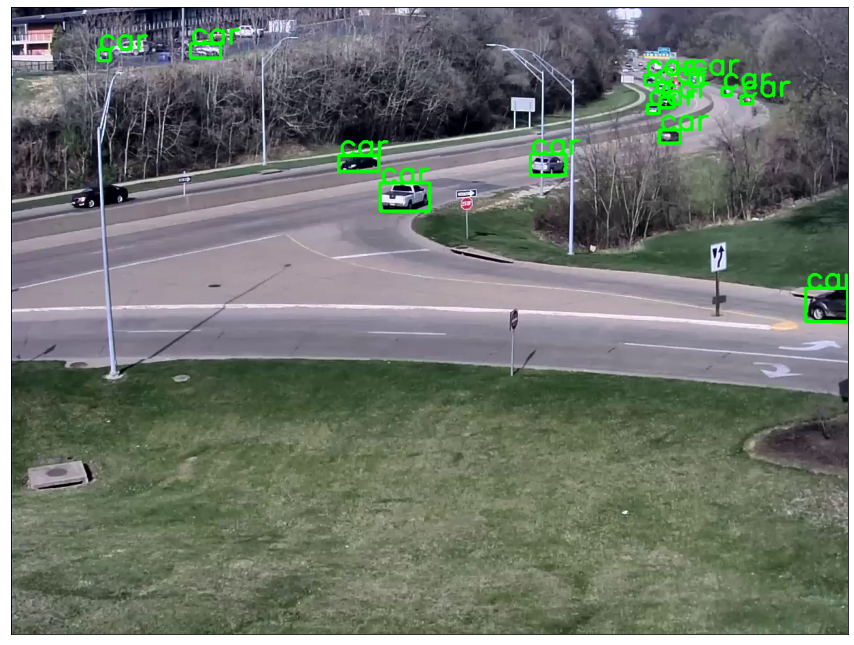

In [ ]:
# Defining a api function for object detection

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):
 
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(15,20)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  
object_detection_api(img_ex_path,threshold=0.8)  

In [ ]:
import matplotlib.pylab as plt
import cv2
# Defining a function for get a prediction result from the model
def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  pred_score= pred_class[:pred_t+1]
  return pred_boxes, pred_class,pred_score

In [ ]:
for key in odata.keys():   
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    overlay = det_img.copy()
    det_result = data[key] 
    
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 1: # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    
    mot_imgid = key.replace('.jpg','')
    newname = save_path + mot_imgid + '_mot.jpg'
    print(mot_imgid)
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        x2 = int(ele[2])
        y2 = int(ele[3])
        track_label = str(int(ele[4])) 
        cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
        cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
        
    cv2.imwrite(newname,det_img)

In [ ]:
# Defining a api function for object detection

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):
 
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(15,20)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


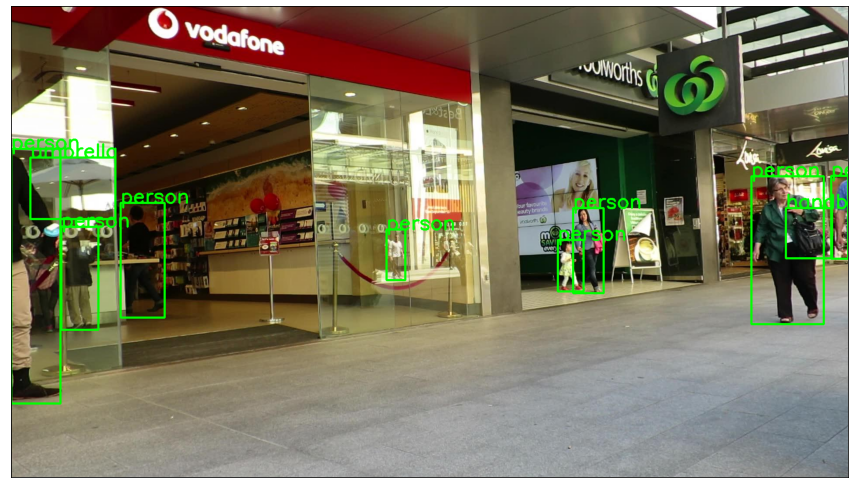

In [ ]:
# Example: After detection
object_detection_api(img_ex_path,threshold=0.8)





*   The picture above is an example of applying Detection Network (in our case, Faster R-CNN).
*   Since the purpose of dataset we are using is 'tracking', you can see that most of the detected classes are 'person'.
*   We need a prediction result (bbs offset, class label, pred scores) for all the images.






---


**3. Object ID Tracking with SORT**


*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking 

---



In [ ]:
# Git clone: SORT Algorithm

!cd "{MOT_PATH}";git clone https://github.com/abewley/sort.git
  
sort = join(MOT_PATH,'sort/')
sys.path.append(sort)

Cloning into 'sort'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 202 (delta 0), reused 0 (delta 0), pack-reused 198
Receiving objects: 100% (202/202), 1.21 MiB | 11.75 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
# requirement for sort
!cd "{sort}";pip install -r requirements.txt

     |████████████████████████████████| 177 kB 32.3 MB/s 
     |████████████████████████████████| 12.5 MB 63.8 MB/s 
     |████████████████████████████████| 1.5 MB 69.6 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=4a540a83ee1d302e2facea9517346cfcd25ec33e426dc8f4873d4ff470cce35e
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590152 sha256=65db7e2e99b663a639cb70ba63976be649a0b8d69e394f54fe70f50416d4e99a
  Stored in directory: /root/.cache/pip/wheels/b1/0b/e3/ef9daf1b5547b56389e42c80c3100f1e6479bf5fd00fd9d6ba
Successfully built filterpy lap
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages t

In [ ]:
# Optional: if error occurs, you might need to re-install scikit-image and imgaug

!pip uninstall scikit-image
!pip uninstall imgaug
!pip install imgaug
!pip install -U scikit-image

import skimage
print(skimage.__version__)

Found existing installation: scikit-image 0.18.3
Uninstalling scikit-image-0.18.3:
  Would remove:
    /usr/local/bin/skivi
    /usr/local/lib/python3.7/dist-packages/scikit_image-0.18.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_image.libs/libgomp-3300acd3.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/skimage/*
Proceed (y/n)? ERROR: Operation cancelled by user
Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.2.9.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)?   ERROR: Operation cancelled by user
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  Fil

In [ ]:
# Detection information on all the images is well-refined as a json file, which is available at our course git repo

!cd "{MOT_PATH}";git clone https://github.com/mlvlab/COSE474.git

Cloning into 'COSE474'...
remote: Enumerating objects: 186, done.
remote: Total 186 (delta 0), reused 0 (delta 0), pack-reused 186
Receiving objects: 100% (186/186), 40.65 MiB | 20.91 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
import json
import collections
from pprint import pprint
import matplotlib
matplotlib.use('TKAgg')

import matplotlib.pyplot as plt
from os.path import join

jsonpath = join(MOT_PATH,'COSE474/3_MOT_detinfo.json')
img_path = motdata    # img root path


with open(jsonpath) as data_file:    
   data = json.load(data_file)
odata = collections.OrderedDict(sorted(data.items()))

In [ ]:
# Let's check out downloaded json file

#pprint(odata)



---



*   For each image, bbs offset, class label, pred scores are all annotated.
*   Labels are annotated as a number - not a word, and for further information, go to the website below.
* https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/ 



---



In [ ]:
img_path = motdata    # img root path

# Making new directory for saving results
save_path = join(MOT_PATH,'save/')
!mkdir "{save_path}"

In [ ]:
odata.keys()

odict_keys(['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000023.jpg', '000024.jpg', '000025.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000038.jpg', '000039.jpg', '000040.jpg', '000041.jpg', '000042.jpg', '000043.jpg', '000044.jpg', '000045.jpg', '000046.jpg', '000047.jpg', '000048.jpg', '000049.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000053.jpg', '000054.jpg', '000055.jpg', '000056.jpg', '000057.jpg', '000058.jpg', '000059.jpg', '000060.jpg', '000061.jpg', '000062.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000067.jpg', '000068.jpg', '000069.jpg', '000070.jpg', '000071.

In [ ]:

key = '000001.jpg'
arrlist = []
det_img = cv2.imread(os.path.join(motdata, key))
overlay = det_img.copy()
det_result = data[key] 

for info in det_result:
    bbox = info['bbox']
    labels = info['labels']
    scores = info['scores']
    templist = bbox+[scores]

In [ ]:
templist

[46.312843322753906,
 346.5391540527344,
 237.5765380859375,
 472.7368469238281,
 0.8219917416572571]

In [ ]:

for key in odata.keys():   
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    overlay = det_img.copy()
    det_result = data[key] 
    
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 1: # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            

In [ ]:
#arrlist

In [ ]:
mot_tracker = Sort()      # Tracker using SORT Algorithm

In [ ]:
for key in odata.keys():   
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    overlay = det_img.copy()
    det_result = data[key] 
    
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 1: # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    
    mot_imgid = key.replace('.jpg','')
    newname = save_path + mot_imgid + '_mot.jpg'
    print(mot_imgid)
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        x2 = int(ele[2])
        y2 = int(ele[3])
        track_label = str(int(ele[4])) 
        cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
        cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
        
    cv2.imwrite(newname,det_img)

000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049
000050
000051
000052
000053
000054
000055
000056
000057
000058
000059
000060
000061
000062
000063
000064
000065
000066
000067
000068
000069
000070
000071
000072
000073
000074
000075
000076
000077
000078
000079
000080
000081
000082
000083
000084
000085
000086
000087
000088
000089
000090
000091
000092
000093
000094
000095
000096
000097
000098
000099
000100
000101
000102
000103
000104
000105
000106
000107
000108
000109
000110
000111
000112
000113
000114
000115
000116
000117
000118
000119
000120
000121
000122
000123
000124
000125
000126
000127
000128
000129
000130
000131
000132
000133
000134
000135
000136
000137
000138
000139
000140
000141
000142
000143


---
It's all done!


*   Finally, you can get a sequence of image with each Tracking ID for every detected person. 
*   Check '3_MOT_result.gif' for whole demo experience.



---




# **rainy**

In [ ]:
%%time

pathi='/content/drive/MyDrive/coco/'
save_path = join(pathi,'revision_rainy_cam1_pretrained_byte_DETR/')
!mkdir "{save_path}"


import os 
path='/content/drive/MyDrive/Collab Notebooks/DETR_training/data/rainy/train2017/'
list_cam1data = os.listdir(path)  
list_cam1data.sort()
import re
from os.path import join
import matplotlib.pylab as plt
import cv2
online_targets_all=[]
lista=[]
for j in range(len(list_cam1data)):

  img_ex_path =path+list_cam1data[j]
  im = Image.open(img_ex_path)
  det_img = cv2.imread(img_ex_path)
  img = transform(im).unsqueeze(0)

# propagate through the model
  outputs = model(img)

# keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  scores=[]
  for p in probas[keep]:
    cl = p.argmax()
    score=p[cl].item()
    scores.append(score)

  tempall=[]
  for i in range(len(bboxes_scaled)):
    temp=[bboxes_scaled[i][0].item(),bboxes_scaled[i][1].item(),bboxes_scaled[i][2].item(),bboxes_scaled[i][3].item(),scores[i]]
    tempall.append(temp)

  if (len(tempall)>0):
    online_targets = tracker.update(np.vstack(tempall),[1280, 960],[1280, 960])
  else:
    continue

  mot_imgid = list_cam1data[j].replace('.PNG','')
  newname = save_path + mot_imgid + '_mot.PNG'
  
  for k in range(len(online_targets)):  
      ele = online_targets[k].tlwh
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(online_targets[k].track_id)) 
      cv2.rectangle(det_img, (x, y), (x+x2, y+y2), (0, 255, 255), 2)
      cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
      tmp=int(re.findall('\d+', list_cam1data[j] )[0]),int(track_label), x,y,x2,y2,1,1,1
      lista.append(tmp)




  cv2.imwrite(newname,det_img)
  #print(newname)



  #print(list_cam1data[j])
a=pd.DataFrame(lista)



a.to_csv('/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/rainy_cam1_trainset/revision_DETR_Byte_cam1_rainy_trainset/seq_01.txt', sep=',', index=False, header=False)
!python -m motmetrics.apps.eval_motchallenge '/content/drive/MyDrive/Collab Notebooks/gt/rainy_cam1_trainset/' '/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/rainy_cam1_trainset/revision_DETR_Byte_cam1_rainy_trainset/'


mkdir: cannot create directory ‘/content/drive/MyDrive/coco/revision_rainy_cam1_pretrained_byte_DETR/’: File exists


/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


FileNotFoundError: ignored

In [ ]:
import cv2
import os

save_path = '/content/drive/MyDrive/coco/'+'revision_rainy_cam1_pretrained_byte_DETR/'

image_folder = save_path
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".PNG")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [ ]:
video

< cv2.VideoWriter 0x7fbb55dc30f0>

# **down**

In [ ]:
%%time

import warnings
warnings.filterwarnings('ignore')

pathi='/content/drive/MyDrive/coco/'
save_path = join(pathi,'save_trainset_frames_down_cam1_pretrained_byte_DETR/')
!mkdir "{save_path}"

import os 
path='/content/drive/MyDrive/Collab Notebooks/DETR_training/data/down/train2017/'
list_cam1data = os.listdir(path)  
list_cam1data.sort()
import re
from os.path import join
import matplotlib.pylab as plt
import cv2
online_targets_all=[]
lista=[]
for j in range(len(list_cam1data)):

  img_ex_path =path+list_cam1data[j]
  im = Image.open(img_ex_path)
  det_img = cv2.imread(img_ex_path)
  img = transform(im).unsqueeze(0)

# propagate through the model
  outputs = model(img)

# keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  scores=[]
  for p in probas[keep]:
    cl = p.argmax()
    score=p[cl].item()
    scores.append(score)

  tempall=[]
  for i in range(len(bboxes_scaled)):
    temp=[bboxes_scaled[i][0].item(),bboxes_scaled[i][1].item(),bboxes_scaled[i][2].item(),bboxes_scaled[i][3].item(),scores[i]]
    tempall.append(temp)

  if (len(tempall)>0):
    online_targets = tracker.update(np.vstack(tempall),[1280, 960],[1280, 960])
  else:
    continue


  mot_imgid = list_cam1data[j].replace('.PNG','')
  newname = save_path + mot_imgid + '_mot.PNG'
  
  for k in range(len(online_targets)):  
      ele = online_targets[k].tlwh
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(online_targets[k].track_id)) 
      cv2.rectangle(det_img, (x, y), (x+x2, y+y2), (0, 255, 255), 2)
      cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
      tmp=int(re.findall('\d+', list_cam1data[j] )[0]),int(track_label), x,y,x2,y2,1,1,1
      lista.append(tmp)




  cv2.imwrite(newname,det_img)
  #print(newname)



  #print(list_cam1data[j])
a=pd.DataFrame(lista)


a.to_csv('/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/down_cam1_trainset/pretrained_DETR_Byte_cam1_down_trainset/seq_01.txt', sep=',', index=False, header=False)


!python -m motmetrics.apps.eval_motchallenge '/content/drive/MyDrive/Collab Notebooks/gt/down_cam1_trainset/' '/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/down_cam1_trainset/pretrained_DETR_Byte_cam1_down_trainset/'

mkdir: cannot create directory ‘/content/drive/MyDrive/coco/save_trainset_frames_down_cam1_pretrained_byte_DETR/’: File exists
05:59:12 INFO - Found 1 groundtruths and 1 test files.
05:59:12 INFO - Available LAP solvers ['lap', 'scipy']
05:59:12 INFO - Default LAP solver 'lap'
05:59:12 INFO - Loading files.
05:59:12 INFO - Comparing seq_01...
05:59:13 INFO - Running metrics
05:59:13 INFO - partials: 0.124 seconds.
05:59:13 INFO - mergeOverall: 0.127 seconds.
         IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML   FP   FN IDs  FM   MOTA  MOTP IDt IDa IDm
seq_01  25.6% 25.9% 25.3% 26.2% 26.9% 46  0 14 32 2083 2155  16  67 -45.6% 0.407   4   9   1
OVERALL 25.6% 25.9% 25.3% 26.2% 26.9% 46  0 14 32 2083 2155  16  67 -45.6% 0.407   4   9   1
05:59:13 INFO - Completed
CPU times: user 35min 10s, sys: 1min 48s, total: 36min 59s
Wall time: 42min 27s


# **Cam2**

In [ ]:
!pip install ipython-autotime

%load_ext autotime

time: 168 µs (started: 2022-03-12 22:28:00 +00:00)


In [ ]:
pip install git+https://github.com/cheind/py-motmetrics.git

  Cloning https://github.com/cheind/py-motmetrics.git to /tmp/pip-req-build-xk5klt_t
  Running command git clone -q https://github.com/cheind/py-motmetrics.git /tmp/pip-req-build-xk5klt_t
time: 9.7 s (started: 2022-03-12 22:28:00 +00:00)


In [ ]:

import warnings
warnings.filterwarnings('ignore')

pathi='/content/drive/MyDrive/coco/'
save_path = join(pathi,'save_frames_cam2_pretrained_byte_DETR/')
!mkdir "{save_path}"

import os 
path='/content/drive/MyDrive/Collab Notebooks/input_images/cam2/sunny/img1/'
list_cam1data = os.listdir(path)  
list_cam1data.sort()
import re
from os.path import join
import matplotlib.pylab as plt
import cv2
online_targets_all=[]
lista=[]
for j in range(len(list_cam1data)):

  img_ex_path =path+list_cam1data[j]
  im = Image.open(img_ex_path)
  det_img = cv2.imread(img_ex_path)
  img = transform(im).unsqueeze(0)

# propagate through the model
  outputs = model(img)

# keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  scores=[]
  for p in probas[keep]:
    cl = p.argmax()
    score=p[cl].item()
    scores.append(score)

  tempall=[]
  for i in range(len(bboxes_scaled)):
    temp=[bboxes_scaled[i][0].item(),bboxes_scaled[i][1].item(),bboxes_scaled[i][2].item(),bboxes_scaled[i][3].item(),scores[i]]
    tempall.append(temp)

  if (len(tempall)>0):
    online_targets = tracker.update(np.vstack(tempall),[1280, 720],[1280, 720])
  else:
    continue


  mot_imgid = list_cam1data[j].replace('.PNG','')
  newname = save_path + mot_imgid + '_mot.PNG'
  
  for k in range(len(online_targets)):  
      ele = online_targets[k].tlwh
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(online_targets[k].track_id)) 
      cv2.rectangle(det_img, (x, y), (x+x2, y+y2), (0, 255, 255), 2)
      cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
      tmp=int(re.findall('\d+', list_cam1data[j] )[0]),int(track_label), x,y,x2,y2,1,1,1
      lista.append(tmp)




  cv2.imwrite(newname,det_img)
  #print(newname)



  #print(list_cam1data[j])
a=pd.DataFrame(lista)


a.to_csv('/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/cam2/pretrained_DETR_Byte_cam2/seq_01.txt', sep=',', index=False, header=False)


!python -m motmetrics.apps.eval_motchallenge '/content/drive/MyDrive/Collab Notebooks/gt/sunny_cam2/' '/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/cam2/pretrained_DETR_Byte_cam2/'

11:27:20 INFO - Found 1 groundtruths and 1 test files.
11:27:20 INFO - Available LAP solvers ['lap', 'scipy']
11:27:20 INFO - Default LAP solver 'lap'
11:27:20 INFO - Loading files.
11:27:21 INFO - Comparing seq_01...
11:27:22 INFO - Running metrics
11:27:22 INFO - partials: 0.216 seconds.
11:27:22 INFO - mergeOverall: 0.219 seconds.
         IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML   FP   FN IDs   FM  MOTA  MOTP IDt IDa IDm
seq_01  53.6% 61.8% 47.3% 50.7% 66.3% 70  5 58  7 1767 3372  50  317 24.2% 0.336  15  28   4
OVERALL 53.6% 61.8% 47.3% 50.7% 66.3% 70  5 58  7 1767 3372  50  317 24.2% 0.336  15  28   4
11:27:22 INFO - Completed
time: 52min 34s (started: 2022-03-12 22:34:48 +00:00)


# **Cam13**

In [ ]:
%%time 

import warnings
warnings.filterwarnings('ignore')

pathi='/content/drive/MyDrive/coco/'
save_path = join(pathi,'save_frames_cam13_pretrained_byte_DETR/')
!mkdir "{save_path}"

import os 
path='/content/drive/MyDrive/Collab Notebooks/input_images/cam13/img1/'
list_cam1data = os.listdir(path)  
list_cam1data.sort()
import re
from os.path import join
import matplotlib.pylab as plt
import cv2
online_targets_all=[]
lista=[]
for j in range(len(list_cam1data)):

  img_ex_path =path+list_cam1data[j]
  im = Image.open(img_ex_path)
  det_img = cv2.imread(img_ex_path)
  img = transform(im).unsqueeze(0)

# propagate through the model
  outputs = model(img)

# keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  scores=[]
  for p in probas[keep]:
    cl = p.argmax()
    score=p[cl].item()
    scores.append(score)

  tempall=[]
  for i in range(len(bboxes_scaled)):
    temp=[bboxes_scaled[i][0].item(),bboxes_scaled[i][1].item(),bboxes_scaled[i][2].item(),bboxes_scaled[i][3].item(),scores[i]]
    tempall.append(temp)

  if (len(tempall)>0):
    online_targets = tracker.update(np.vstack(tempall),[1920, 1080],[1920, 1080])
  else:
    continue


  mot_imgid = list_cam1data[j].replace('.PNG','')
  newname = save_path + mot_imgid + '_mot.PNG'
  
  for k in range(len(online_targets)):  
      ele = online_targets[k].tlwh
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(online_targets[k].track_id)) 
      cv2.rectangle(det_img, (x, y), (x+x2, y+y2), (0, 255, 255), 2)
      cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
      tmp=int(re.findall('\d+', list_cam1data[j] )[0]),int(track_label), x,y,x2,y2,1,1,1
      lista.append(tmp)




  cv2.imwrite(newname,det_img)
  #print(newname)



  #print(list_cam1data[j])
a=pd.DataFrame(lista)


a.to_csv('/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/cam13/pretrained_DETR_Byte_cam13/seq_01.txt', sep=',', index=False, header=False)


!python -m motmetrics.apps.eval_motchallenge '/content/drive/MyDrive/Collab Notebooks/gt/cam13/' '/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/cam13/pretrained_DETR_Byte_cam13/'

mkdir: cannot create directory ‘/content/drive/MyDrive/coco/save_frames_cam13_pretrained_byte_DETR/’: File exists
08:40:00 INFO - Found 1 groundtruths and 1 test files.
08:40:00 INFO - Available LAP solvers ['lap', 'scipy']
08:40:00 INFO - Default LAP solver 'lap'
08:40:00 INFO - Loading files.
08:40:00 INFO - Comparing seq_01...
08:40:02 INFO - Running metrics
08:40:02 INFO - partials: 0.150 seconds.
08:40:02 INFO - mergeOverall: 0.152 seconds.
         IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML   FP  FN IDs  FM   MOTA  MOTP IDt IDa IDm
seq_01  48.6% 35.6% 76.7% 76.8% 35.7% 47  7 37  3 2485 415   2  37 -61.9% 0.300   0   2   0
OVERALL 48.6% 35.6% 76.7% 76.8% 35.7% 47  7 37  3 2485 415   2  37 -61.9% 0.300   0   2   0
08:40:02 INFO - Completed
CPU times: user 53min 59s, sys: 2min 8s, total: 56min 7s
Wall time: 1h 20s


# **cam8**

In [ ]:
%%time


import warnings
warnings.filterwarnings('ignore')

pathi='/content/drive/MyDrive/coco/'
save_path = join(pathi,'save_frames_cam8_pretrained_byte_DETR/')
!mkdir "{save_path}"

import os 
path='/content/drive/MyDrive/Collab Notebooks/input_images/cam8/img1/'
list_cam1data = os.listdir(path)  
list_cam1data.sort()
import re
from os.path import join
import matplotlib.pylab as plt
import cv2
online_targets_all=[]
lista=[]
for j in range(len(list_cam1data)):

  img_ex_path =path+list_cam1data[j]
  im = Image.open(img_ex_path)
  det_img = cv2.imread(img_ex_path)
  img = transform(im).unsqueeze(0)

# propagate through the model
  outputs = model(img)

# keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.9

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  scores=[]
  for p in probas[keep]:
    cl = p.argmax()
    score=p[cl].item()
    scores.append(score)

  tempall=[]
  for i in range(len(bboxes_scaled)):
    temp=[bboxes_scaled[i][0].item(),bboxes_scaled[i][1].item(),bboxes_scaled[i][2].item(),bboxes_scaled[i][3].item(),scores[i]]
    tempall.append(temp)

  if (len(tempall)>0):
    online_targets = tracker.update(np.vstack(tempall),[1920, 1080],[1920, 1080])
  else:
    continue


  mot_imgid = list_cam1data[j].replace('.PNG','')
  newname = save_path + mot_imgid + '_mot.PNG'
  
  for k in range(len(online_targets)):  
      ele = online_targets[k].tlwh
      x = int(ele[0])
      y = int(ele[1])
      x2 = int(ele[2])
      y2 = int(ele[3])
      track_label = str(int(online_targets[k].track_id)) 
      cv2.rectangle(det_img, (x, y), (x+x2, y+y2), (0, 255, 255), 2)
      cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
      tmp=int(re.findall('\d+', list_cam1data[j] )[0]),int(track_label), x,y,x2,y2,1,1,1
      lista.append(tmp)




  cv2.imwrite(newname,det_img)
  #print(newname)



  #print(list_cam1data[j])
a=pd.DataFrame(lista)


a.to_csv('/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/cam8/pretrained_DETR_Byte_cam8/seq_01.txt', sep=',', index=False, header=False)


!python -m motmetrics.apps.eval_motchallenge '/content/drive/MyDrive/Collab Notebooks/gt/cam8/' '/content/drive/MyDrive/Collab Notebooks/detections/DETR_Byte/cam8/pretrained_DETR_Byte_cam8/'

mkdir: cannot create directory ‘/content/drive/MyDrive/coco/save_frames_cam8_pretrained_byte_DETR/’: File exists
10:47:46 INFO - Found 1 groundtruths and 1 test files.
10:47:46 INFO - Available LAP solvers ['lap', 'scipy']
10:47:46 INFO - Default LAP solver 'lap'
10:47:46 INFO - Loading files.
10:47:46 INFO - Comparing seq_01...
10:47:48 INFO - Running metrics
10:47:48 INFO - partials: 0.120 seconds.
10:47:48 INFO - mergeOverall: 0.123 seconds.
         IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP  FN IDs  FM  MOTA  MOTP IDt IDa IDm
seq_01  57.9% 54.0% 62.5% 65.8% 56.9% 27  8 16  3 939 643   7  74 15.6% 0.330   2   7   2
OVERALL 57.9% 54.0% 62.5% 65.8% 56.9% 27  8 16  3 939 643   7  74 15.6% 0.330   2   7   2
10:47:48 INFO - Completed
CPU times: user 56min 18s, sys: 4min 10s, total: 1h 28s
Wall time: 1h 2min 6s
